In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -U tables

     |████████████████████████████████| 4.3MB 5.0MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [0]:
import pandas as pd
import numpy as np
import h5py as h5
import tables
import os
import matplotlib.pyplot as plt
import pickle

In [4]:
main_dir = '/content/drive/My Drive/OZNAL - regression model'
os.listdir(main_dir)

['doc2vec',
 'Predspracovanie.ipynb',
 'data',
 'validation_final.h5',
 'y_validation.h5',
 'train_final.h5',
 'models',
 'x_test.h5',
 'y_test.h5',
 'y_train.h5',
 'logs',
 'ctest.h5',
 'ctrain.h5',
 'ceval.h5',
 'Regression.ipynb']

In [0]:
# train_file.close()
# test_file.close()
# validation_file.close()

In [5]:
train_file = tables.open_file(f'{main_dir}/ctrain.h5', mode="r")
validation_file = tables.open_file(f'{main_dir}/ceval.h5', mode="r")
test_file = tables.open_file(f'{main_dir}/ctest.h5', mode="r")

# print(test_file)
print(train_file, validation_file, test_file)
INPUT_SIZE = train_file.get_node('/x').shape[1]
print(INPUT_SIZE)

/content/drive/My Drive/OZNAL - regression model/ctrain.h5 (File) ''
Last modif.: 'Sat May 11 10:46:12 2019'
Object Tree: 
/ (RootGroup) ''
/x (CArray(640000, 2980), shuffle, blosc(5)) ''
/y (CArray(640000, 1), shuffle, blosc(5)) ''
 /content/drive/My Drive/OZNAL - regression model/ceval.h5 (File) ''
Last modif.: 'Sat May 11 10:46:26 2019'
Object Tree: 
/ (RootGroup) ''
/x (CArray(160000, 2980), shuffle, blosc(5)) ''
/y (CArray(160000, 1), shuffle, blosc(5)) ''
 /content/drive/My Drive/OZNAL - regression model/ctest.h5 (File) ''
Last modif.: 'Sat May 11 10:45:26 2019'
Object Tree: 
/ (RootGroup) ''
/x (CArray(400000, 2980), shuffle, blosc(5)) ''
/y (CArray(400000, 1), shuffle, blosc(5)) ''

2980


In [0]:
def get_boundaries(length, chunksize):
    boundaries = []
    for i in range(int(np.ceil(length / chunksize))):
        boundaries.append([chunksize * i, chunksize * (i+1)])
        
    return np.array(boundaries)

In [0]:
def generator(store, batch_size):
  x_data = train_file.get_node('/x')
  y_data = train_file.get_node('/y')
  
  samples_per_epoch = x_data.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter=0
  chunksize = 100
  boundaries = get_boundaries(samples_per_epoch, chunksize)
  
  
  while 1:
    start = batch_size * counter
    stop = batch_size * (counter+1)
    
#     print('[boundaries]', start // chunksize, stop // chunksize)
    x = np.stack([x_data[boundaries[i, 0]: boundaries[i, 1]] for i in range(start // chunksize, stop // chunksize)])
    y = np.stack([y_data[boundaries[i, 0]: boundaries[i, 1]] for i in range(start // chunksize, stop // chunksize)])
    
    X_batch = np.concatenate(x[:]).astype('float32')
    y_batch = np.concatenate(y[:]).astype('float32')
    counter += 1
    yield X_batch,y_batch

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        np.random.shuffle(boundaries)
        counter = 0

### Generator

In [0]:
train_gen = generator(validation_file, batch_size=2000)

In [0]:
for i in range(320):
  x, y = next(train_gen)
  print(i, x.shape, y.shape)

In [18]:
x, y = next(train_gen)
x.shape, x.dtype, np.unravel_index(x.argmin(), x.shape), np.max(x), np.sum(np.isnan(x))

((2000, 2980), dtype('float32'), (997, 2898), 4.859775, 0)

## Training MLP

In [0]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


In [0]:
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [0]:
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [0]:
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(1 + y_pred) - K.log(1 + y_true)))) 

## Deep architecture with Dropout

In [57]:
MODEL = "MLP-256H-128H-64H-DO"
HIDDEN_SIZE = (256, 128, 64)
l2_reg = l2(0.0001)

model = Sequential()
model.add(Dense(HIDDEN_SIZE[0], input_dim=INPUT_SIZE, kernel_initializer='normal', kernel_regularizer=l2_reg, bias_regularizer=l2_reg))
# model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Dropout(0.2))
if len(HIDDEN_SIZE) >= 2:
  model.add(Dense(HIDDEN_SIZE[1], input_dim=INPUT_SIZE, kernel_initializer='normal', kernel_regularizer=l2_reg, bias_regularizer=l2_reg))
#   model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
if len(HIDDEN_SIZE) >= 3:
  model.add(Dense(HIDDEN_SIZE[2], input_dim=INPUT_SIZE, kernel_initializer='normal', kernel_regularizer=l2_reg, bias_regularizer=l2_reg))
#   model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
model.add(Dense(1, activation='linear', kernel_regularizer=l2_reg, bias_regularizer=l2_reg))
model.summary()

model.compile(loss=rmsle, optimizer='adam', metrics=['mse','mae'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               763136    
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
___________________________

### Shallow model

In [32]:
MODEL = "MLP-105H"
HIDDEN_SIZE = (105,)
l2_reg = l2(0.0001)

model = Sequential()
model.add(Dense(HIDDEN_SIZE[0], input_dim=INPUT_SIZE, kernel_initializer='normal', kernel_regularizer=l2_reg, bias_regularizer=l2_reg, activation='relu'))
if len(HIDDEN_SIZE) == 2:
  model.add(Dense(HIDDEN_SIZE[1], kernel_initializer='normal', kernel_regularizer=l2_reg, bias_regularizer=l2_reg, activation='relu'))
model.add(Dense(1, activation='linear', kernel_regularizer=l2_reg, bias_regularizer=l2_reg))
model.summary()

model.compile(loss=rmsle, optimizer='adam', metrics=['mse','mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 105)               313005    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 106       
Total params: 313,111
Trainable params: 313,111
Non-trainable params: 0
_________________________________________________________________


In [11]:
validation_data = (validation_file.get_node('/x')[:], validation_file.get_node('/y')[:])
print(validation_data.shape)

AttributeError: ignored

In [58]:
EPOCHS = 30
BATCH_SIZE = 2000

model_checkpoint = ModelCheckpoint(f'{main_dir}/models/checkpoint/{MODEL}.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
# tensorboard_clbck = TensorBoard(log_dir='f'{main_dir}/tensorboard', histogram_freq=0, write_graph=True, write_images=True)

train_gen = generator(train_file, batch_size=BATCH_SIZE)
valid_gen = generator(validation_file, batch_size=BATCH_SIZE)

# model.fit(x_train, y_train, batch_size=1000, epochs=100, validation_data=(x_val, y_val), callbacks=[model_checkpoint])

TRAIN_STEPS = train_file.get_node('/x').shape[0] // BATCH_SIZE
VALIDATION_STEPS = validation_file.get_node('/x').shape[0] // BATCH_SIZE
print(f'[Model] {MODEL} Steps:', TRAIN_STEPS, VALIDATION_STEPS)

history = model.fit_generator(
    generator=train_gen,
    epochs=EPOCHS,
    verbose=1,
    steps_per_epoch=TRAIN_STEPS,
    validation_data=validation_data,
    validation_steps=VALIDATION_STEPS,
    callbacks=[model_checkpoint]
)

[Model] MLP-256H-128H-64H-DO Steps: 320 80
Epoch 1/30
160000/160000 [==============================] - 4s 23us/sample - loss: 0.5992 - mean_squared_error: 1234.5049 - mean_absolute_error: 12.8739

Epoch 00001: val_loss improved from inf to 0.59924, saving model to /content/drive/My Drive/OZNAL - regression model/models/checkpoint/MLP-256H-128H-64H-DO.hdf5
320/320 [==============================] - 33s 102ms/step - loss: 0.7875 - mean_squared_error: 1409.1021 - mean_absolute_error: 15.0187 - val_loss: 0.5992 - val_mean_squared_error: 1234.5049 - val_mean_absolute_error: 12.8739
Epoch 2/30
160000/160000 [==============================] - 4s 22us/sample - loss: 0.5712 - mean_squared_error: 1154.5005 - mean_absolute_error: 12.3456

Epoch 00002: val_loss improved from 0.59924 to 0.57120, saving model to /content/drive/My Drive/OZNAL - regression model/models/checkpoint/MLP-256H-128H-64H-DO.hdf5
320/320 [==============================] - 35s 109ms/step - loss: 0.5968 - mean_squared_error: 11

In [0]:
# Save model
model.save(f'{main_dir}/models/{MODEL}.hdf5')

### Save history

In [62]:
OPEN_MODEL = MODEL
print(OPEN_MODEL)

MLP-256H-128H-64H-DO


In [0]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

### Load history

In [0]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'rb') as input:
    input_data4 = pickle.load(input)

In [0]:
input_data1 = input_data

In [0]:
models = ['FFNNS', 'FFNNI', 'FFNND', 'FFNNDD']
input_data = [input_data1, input_data2, input_data3, input_data4]

## Evaluate training

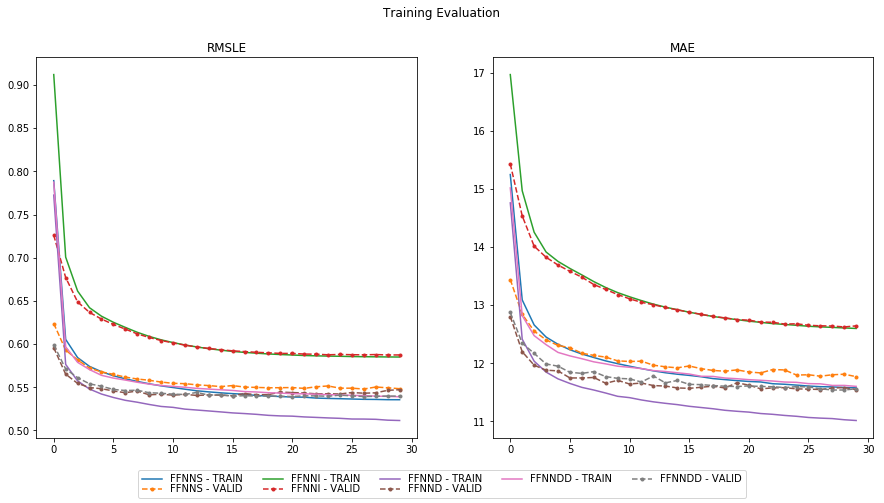

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
labels = []
for i in range(len(input_data)):
    axs[0].plot(input_data[i]["loss"])
    axs[0].plot(input_data[i]["val_loss"], '.--')
    axs[0].set_title("RMSLE")
#     axs[1].plot(input_data[i]["mean_squared_error"])
#     axs[1].plot(input_data[i]["val_mean_squared_error"], '.--')
#     axs[1].set_title("MSE")
    axs[1].plot(input_data[i]["mean_absolute_error"])
    axs[1].plot(input_data[i]["val_mean_absolute_error"], '.--')
    axs[1].set_title("MAE")
    
    labels.append(f'{models[i]} - TRAIN')
    labels.append(f'{models[i]} - VALID')
    
fig.suptitle('Training Evaluation')
plt.figlegend(labels, loc = 'lower center', ncol=5, labelspacing=0. )

## Load MODEL

In [0]:
MODEL = 'MLP-105H'

In [126]:
model = load_model(f'{main_dir}/models/checkpoint/{MODEL}.hdf5', custom_objects={'rmsle': rmsle})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 105)               313005    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 106       
Total params: 313,111
Trainable params: 313,111
Non-trainable params: 0
_________________________________________________________________


In [0]:
test = generator(test_file, batch_size=1000)
TEST_SIZE = test_file.get_node('/x').shape[0]

In [0]:
evaluations = []

In [129]:
print('All', TEST_SIZE)
for i in range(TEST_SIZE // 1000):
  x, y = next(test)
  eval = model.evaluate(x, y)
  evaluations.append(eval)
#   print(i, x.shape, y.shape)

All 400000
1000/1000 [==============================] - 0s 62us/sample - loss: 0.5614 - mean_squared_error: 1024.5568 - mean_absolute_error: 13.0035


In [130]:
evals = np.array(evaluations)
print('RMSLE:', np.around(np.mean(evals[:,0]), 4))
print('MAE:', np.around(np.mean(evals[:,2]), 4))

RMSLE: 0.5754
MAE: 12.5607
